Import

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torchvision import transforms as T
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import cv2
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import time

import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
import seaborn
from jupyterthemes import jtplot

os.environ['CUDA_VISIBLE_DEVICES'] = "0, 1, 2, 3"

Augmentation

In [ ]:
def select_aug(aug_list):
    transforms = []
    
    for i in aug_list:
        if i == 'ColorJitter':
            transforms.append(T.ColorJitter(brightness=.5, hue=.3))
        elif i == 'GaussianBlur':
            transforms.append(T.GaussianBlur(kernel_size = (3, 9), sigma = (0.1, 5)))
        elif i == 'RandomCrop':
            transforms.append(T.RandomCrop(500, 500))
        else:
            print('name error')
            return
    return T.Compose(transforms = transforms)

In [ ]:
class RandomCrop(object): # 샘플 무작위 자르기
    def __init__(self, output_size):
        assert ifinstance(output_size, int)
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size) # 정사각형
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    
    def __call__(self, sample):
        image = sample
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        image = image[top : top+new_h, left : left+new_h]
        
        return image

Load Data

In [ ]:
class DCMdataset(Dataset):
    def __init__(self, filePath, size=(512, 512), n_class=1, augment=False):
        
        self.dataset = pd.read_csv(filePath)
        self.size= size
        self.n_class = n_class
        self.augment = augment
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        data = self.dataset.iloc[idx]
        
        base_path = '/tf/0.DATA/data/images'
        image_path = data['image_id']
        
        image = np.load(os.path.join(base_path, image_path+'.npy')).astype(np.float32)
        image = cv2.resize(image, self.size)
        image = image / np.max(image)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        image = torch.Tensor(image).permute(2, 0, 1)

        
        if self.n_class == 2:
            # 0 : negative / 1 : typical / 2 : determinate
            if data['negative'] == 1:
                label = 0
#             elif data['typical'] == 1:
#                 label = 1
#             elif data['indeterminate'] == 1:
#                 label = 2
        elif self.n_class == 1:
            # 1 : positive / 0 : negative
            if np.array(data['negative']) == 1:
                label = torch.Tensor([0.])
            else:
                label = torch.Tensor([1.])
        
        
        
        sample = {'image':image, 'label':label}
        
#         if self.augment:
#             sample = self.augment(**sample)
        
        
        
        return sample


'''
path = '/tf/0.DATA/data/train.csv'
size= (512, 512)
dataset = DCMdataset(path, size)
loader = DataLoader(dataset, batch_size=1, shuffle=True)
for idx, sample in enumerate(loader):
    print(sample['image'].shape)
    print(sample['label'].shape)
    
    print(sample['image'])
    print(sample['label'])
    
    plt.imshow(sample['image'][0].permute(1, 2, 0))
    break
    '''

"\npath = '/tf/0.DATA/data/train.csv'\nsize= (512, 512)\ndataset = DCMdataset(path, size)\nloader = DataLoader(dataset, batch_size=1, shuffle=True)\nfor idx, sample in enumerate(loader):\n    print(sample['image'].shape)\n    print(sample['label'].shape)\n    \n    print(sample['image'])\n    print(sample['label'])\n    \n    plt.imshow(sample['image'][0].permute(1, 2, 0))\n    break\n    "

EarlyStopping

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.val_loss_min = val_loss
#             self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.val_loss_min = val_loss
#             self.save_checkpoint(val_loss, model)
            self.counter = 0

Model

In [ ]:
class vgg(nn.Module):
    def __init__(self, model_num=0, n_class=1):
        super().__init__()
        
        self.n_class = n_class
        
        # vgg19 or resnet34 or efficientnet
        # model_num - 0 : vgg19, 1 : resnet34, else : efficientnet
        if model_num == 0:
            self.pretrained = models.vgg19(pretrained=True)
        elif model_num == 1:
            self.pretrained = models.resnet34(pretrained=True)
        else:
            self.pretrained = models.efficientnet_b0(pretrained=True)
        
        self.dense1 = nn.Linear(1000, 512)
        self.dense2 = nn.Linear(512, self.n_class)
        
    def forward(self, x):
        x = self.pretrained(x)
        x = F.relu(self.dense1(x))
        
        if self.n_class == 1:
            x = torch.sigmoid(self.dense2(x))
        elif self.n_class == 3:
            x = F.softmax(self.dense2(x), dim=1)
        
        return x

'''
n_class = 1
model = vgg(n_class)
path = '/tf/0.DATA/data/train.csv'
size= (512, 512)
dataset = DCMdataset(path, size, n_class)
loader = DataLoader(dataset, batch_size=3, shuffle=True)
#cr = nn.CrossEntropyLoss()
cr = nn.BCELoss()
for idx, sample in enumerate(loader):
    image = sample['image']
    label = sample['label']
    
    plt.imshow(image[0].permute(1, 2, 0))
    print('label = ', label)
    print('\n')
    
    result = model(sample['image'])
    print('result = ', result)
    print('\n')
    
    cr_result = cr(result, label)
    print('cr_result = ', cr_result)
    
    print(((result > 0.5) == label).sum())
    break
'''

"\nn_class = 1\nmodel = vgg(n_class)\npath = '/tf/0.DATA/data/train.csv'\nsize= (512, 512)\ndataset = DCMdataset(path, size, n_class)\nloader = DataLoader(dataset, batch_size=3, shuffle=True)\n#cr = nn.CrossEntropyLoss()\ncr = nn.BCELoss()\nfor idx, sample in enumerate(loader):\n    image = sample['image']\n    label = sample['label']\n    \n    plt.imshow(image[0].permute(1, 2, 0))\n    print('label = ', label)\n    print('\n')\n    \n    result = model(sample['image'])\n    print('result = ', result)\n    print('\n')\n    \n    cr_result = cr(result, label)\n    print('cr_result = ', cr_result)\n    \n    print(((result > 0.5) == label).sum())\n    break\n"

Train

In [ ]:
def train(tr_loader, val_loader, epochs, batch_size, param_path, model_num, n_class):
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    print('device : ', device)
    
    min_loss = float('inf')
    early_stopping = EarlyStopping(patience=10)
    
    # model : vgg or efficientnet
    model = vgg(model_num, n_class)
    for param in model.pretrained.parameters():
        param.requires_grad = False
    
    model = nn.DataParallel(model)
    model.to(device)
    
    if n_class == 3:
        criterion = nn.CrossEntropyLoss().to(device)
    elif n_class == 1:
        criterion = nn.BCELoss().to(device)
    optimizer= torch.optim.SGD(model.parameters(), lr=1e-3)
    
    for epoch in range(epochs):
        start = time.time()
        
        # train
        train_loss = 0
        for idx, data in enumerate(tr_loader):
            model.train()
            optimizer.zero_grad()
            
            images = data['image'].to(device)
            label = data['label'].to(device)
            
            output = model(images)
            loss = criterion(output, label)
             
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        # validation
        val_loss = 0
        acc = 0
        total = 0
        with torch.no_grad():
            for i, val_data in enumerate(val_loader):
                model.eval()
                val_images = val_data['image'].to(device)
                val_label = val_data['label'].to(device)

                val_output = model(val_images)
                validation_loss = criterion(val_output, val_label)
                val_loss += validation_loss.item()
                
                if n_class == 3:
                    acc += (torch.argmax(val_output, dim=1) == val_label).sum().item()
                elif n_class == 1:
                    acc += ((val_output > 0.5)==val_label).sum().item()
                total += val_label.size(0)
            
        print(f'epoch : {epoch}, elapsed time : {time.time()-start}')
        print(f'loss : {train_loss/len(tr_loader)}, val_loss : {val_loss/len(val_loader)}, acc : {acc/total*100}')
        
        if (train_loss / len(tr_loader)) < min_loss:
            torch.save(model.module.state_dict(), param_path)
        
        # early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print('')
            print('Early stopping')
            break

In [ ]:
epoch = 400
# (512, 512) 크기에서 batch size 100개 정도 가능
batch_size = 32
size = (512, 512)
# model_num - 0 : vgg19, 1 : resnet34
train_model_num = 0
n_class = 1
param_path = './param_' + 'class_' + str(n_class)

augment = select_aug(['ColorJitter', 'GaussianBlur', 'RandomCrop'])

tr_set = DCMdataset('/tf/0.DATA/data/train.csv', size, n_class, augment=augment)
val_set = DCMdataset('/tf/0.DATA/data/val.csv', size, n_class)
te_set = DCMdataset('/tf/0.DATA/data/train.csv', size, n_class)

tr_loader = DataLoader(tr_set, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
te_loader = DataLoader(te_set, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)

In [ ]:
train(tr_loader, val_loader, epoch, batch_size, param_path, train_model_num, n_class)

Test 

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
test_model_num = 0

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
test_model = vgg(test_model_num, n_class)
test_model.load_state_dict(torch.load(param_path))

test_model = nn.DataParallel(test_model)
test_model.to(device)

test_loss = []
predict = []
cl = []
test_model.eval()
for i, data in enumerate(te_loader):
    if n_class == 3:
        criterion = nn.CrossEntropyLoss().to(device)
    elif n_class == 1:
        criterion = nn.BCELoss().to(device)
    
    image = data['image'].to(device)
    label = data['label'].to(device)
    
    with torch.no_grad():
        output = test_model(image)
    loss = criterion(output, label)
    test_loss.append(loss)
    
    if n_class == 3:
        tmp = torch.argmax(output, dim=1)
    elif n_class == 1:
        tmp = ((output > 0.5)==label)
    tmp = tmp.detach().cpu().numpy()
    label = label.detach().cpu().numpy()
        
    predict.extend(tmp)
    cl.extend(label)

predict = np.array(predict)
cl = np.array(cl)

acc = metrics.accuracy_score(cl, predict)
f1 = metrics.f1_score(cl, predict, average=None)

print(acc)
print(f1)

print(predict)
print(cl)

0.7948717948717948
[0.616      0.86005831]
[[ True]
 [ True]
 [ True]
 ...
 [ True]
 [False]
 [ True]]
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [1.]]


In [ ]:
output

tensor([[0.9375],
        [0.6892],
        [0.8847],
        [0.8941],
        [0.5208],
        [0.5955],
        [0.4736],
        [0.9050],
        [0.8570],
        [0.5701],
        [0.7738],
        [0.7481],
        [0.8859],
        [0.8151],
        [0.3382],
        [0.7571],
        [0.8325],
        [0.4611],
        [0.6754],
        [0.6801],
        [0.6707],
        [0.3413],
        [0.8035],
        [0.3557],
        [0.7647],
        [0.4112],
        [0.5573],
        [0.5612],
        [0.8344],
        [0.3657],
        [0.8743],
        [0.5333]], device='cuda:0')

Evaluation

In [ ]:
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

if n_class == 1:
    class_names = ['negative', 'positive']
# elif n_class == 3:
#     class_names = ['negative', 'typical', 'indeterminate']

report = metrics.classification_report(cl, predict, output_dict=True, target_names=class_names)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
negative,0.738609,0.528302,0.616000,1166.000000
positive,0.810997,0.915438,0.860058,2578.000000
accuracy,0.794872,0.794872,0.794872,0.794872
macro avg,0.774803,0.721870,0.738029,3744.000000
weighted avg,0.788453,0.794872,0.784051,3744.000000


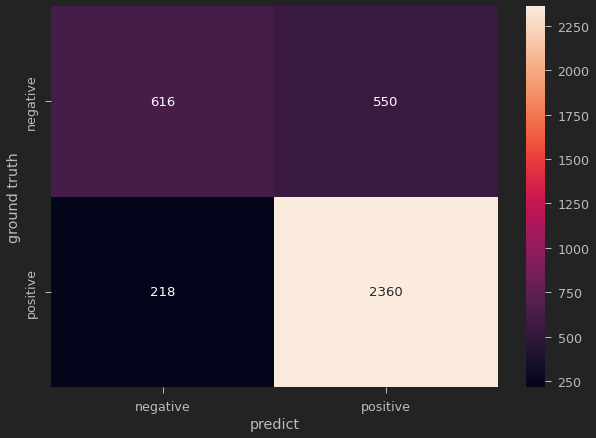

In [ ]:
cf_matrix = confusion_matrix(cl, predict)
df_cm = pd.DataFrame(cf_matrix, index=[i for i in class_names], columns=[i for i in class_names])

fig = plt.figure(figsize=(10 ,7))
seaborn.heatmap(df_cm, annot=True, fmt='d')
plt.xlabel('predict')
plt.ylabel('ground truth')
plt.show()